In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2
import seaborn as sns
import pandas as pd
import torchvision

In [2]:
path_to_data = '/Users/janbraunsdorff/Studienarbeit-projekt/data'
path_to_validation_annotation = path_to_data + "/validation.csv"
path_to_training_annotation = path_to_data + "/training.csv"
path_to_validatoin_data = path_to_data + '/boneage-validation-dataset/'
path_to_training_data = path_to_data + '/boneage-training-dataset/'
path = path_to_data + '/pickel/v3'

In [3]:
model = torch.load('model/vit.pht', map_location=torch.device('cpu'))
model.eval()
print('**done**')

Device:  cpu
**done**


In [4]:
def processImages(img_path, resize_to=500, reduce_to=380, out_to=256):
    img = cv2.imread(img_path)
    size_target = resize_to
    img = cv2.resize(img, (resize_to, resize_to), interpolation=cv2.INTER_LINEAR)

    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    lab_planes = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    lab_planes[0] = clahe.apply(lab_planes[0])
    lab = cv2.merge(lab_planes)
    bgr = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)


    x = y = (size_target - reduce_to) // 2
    h = w = reduce_to
    img = bgr[y:y + h, x:x + w]

    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    lab_planes = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    lab_planes[0] = clahe.apply(lab_planes[0])
    lab = cv2.merge(lab_planes)
    img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

    kernel = np.ones((2,2),np.uint8)
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)

    img = cv2.resize(img, (out_to, out_to), interpolation=cv2.INTER_LINEAR)

    
    return img

def img_to_tensor(base_path):
    img = processImages(img_path=base_path)
    arr = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    t_img = torch.tensor(arr)
    t_img_normalize = t_img.unsqueeze(0)

    return t_img_normalize

In [5]:
#test = torchvision.transforms.functional.crop(img, 0, 0, 128, 128)
#plt.imshow(test.permute(1,2,0).numpy(), cmap='gray')

In [22]:
def getconding(path):
    img = img_to_tensor(path)
    patches = model.patches(img.unsqueeze(0).float())
    encoding = model.encode_patches(patches.float())

    for t in model.transformers:
        x1 = t.norm_1(encoding)
        attention_output = t.mha(x1,x1,x1)
        x2 = attention_output[0] + encoding
        x3 = t.norm_2(x2)
        x3 = t.mlp(x3)
        encoding = x3 + x2

    t = torch.mean(encoding, 2)
    max_value = torch.max(t, dim=1)[0]
    t = t.view(-1, 16, 16)
    t = t / max_value
    t = t.squeeze(0)
    t = t.detach().numpy()
    t2 = t.copy()
    t2[t2<0.5] = 0

    return img, t, t2


<Figure size 144x72 with 0 Axes>

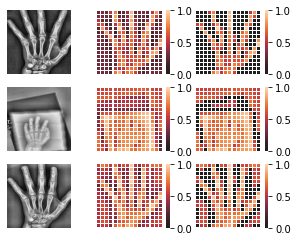

In [23]:
plt.figure(figsize=(2,1))
plt.subplots(figsize=(5,4))

imges = ["1377.png", "1378.png", "1400.png"]

for i in range (3):
    img, t, t2 = getconding(path_to_training_data + imges[i])

    plt.subplot(3, 3, i*3+1)
    plt.imshow(img.permute(1,2,0).detach(), cmap='gray')
    plt.axis('off')

    plt.subplot(3, 3, i*3+2)

    ax = sns.heatmap(
        t,
        cbar=True,
        vmin=0, vmax=1,
        annot=False,
        xticklabels=False, 
        yticklabels=False,
        center=0,
        linewidths=.1
    )

    plt.subplot(3, 3, i*3+3)
    ax = sns.heatmap(
        t2,
        cbar=True,
        vmin=0, vmax=1,
        annot=False,
        xticklabels=False, 
        yticklabels=False,
        center=0,
        linewidths=.1
    )

In [24]:
t = torch.rand(16, 256)
max = torch.max(t, dim=1)[0]

In [41]:
t.shape, max.view(16,1).shape

(torch.Size([16, 256]), torch.Size([16, 1]))

In [43]:
t, max

(tensor([[0.5271, 0.6198, 0.4348,  ..., 0.8926, 0.6619, 0.2631],
         [0.7042, 0.3386, 0.5002,  ..., 0.0290, 0.0716, 0.0229],
         [0.9538, 0.3317, 0.0959,  ..., 0.3397, 0.9906, 0.5073],
         ...,
         [0.6704, 0.7453, 0.7192,  ..., 0.0386, 0.1874, 0.3912],
         [0.5638, 0.7487, 0.8065,  ..., 0.5770, 0.1051, 0.1838],
         [0.6452, 0.6312, 0.8622,  ..., 0.1698, 0.9604, 0.4381]]),
 tensor([0.9995, 0.9918, 0.9906, 0.9983, 0.9946, 0.9959, 0.9970, 0.9989, 0.9931,
         0.9973, 0.9944, 1.0000, 0.9967, 0.9990, 0.9972, 0.9995]))

In [42]:
torch.div(t, max.view(16,1))

tensor([[0.5273, 0.6201, 0.4350,  ..., 0.8930, 0.6622, 0.2633],
        [0.7101, 0.3414, 0.5044,  ..., 0.0292, 0.0722, 0.0231],
        [0.9628, 0.3348, 0.0968,  ..., 0.3429, 1.0000, 0.5121],
        ...,
        [0.6711, 0.7461, 0.7199,  ..., 0.0386, 0.1876, 0.3916],
        [0.5654, 0.7508, 0.8088,  ..., 0.5787, 0.1054, 0.1843],
        [0.6456, 0.6315, 0.8626,  ..., 0.1699, 0.9609, 0.4383]])

In [68]:
img = img_to_tensor(path_to_training_data + "1377.png")
img = img / 255.0
patches = model.patches(img.unsqueeze(0).float())
print(patches.shape)

torch.Size([1, 256, 256])
/usr/local/lib/python3.9/site-packages/torch/tensor.py:447: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


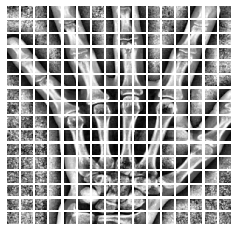

In [56]:
n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4,4))

for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i+1)
    patch_img = patch.reshape(1, 16, 16).permute(1,2,0)
    plt.imshow(patch_img.numpy(), cmap='gray')
    plt.axis('off')

In [66]:
img[0]

tensor([[37, 61, 64,  ..., 62, 60, 64],
        [37, 44, 49,  ..., 55, 59, 61],
        [35, 38, 39,  ..., 60, 55, 59],
        ...,
        [42, 58, 64,  ..., 66, 61, 45],
        [40, 49, 54,  ..., 56, 47, 48],
        [51, 52, 57,  ..., 60, 55, 47]], dtype=torch.uint8)

In [65]:
patches[0]

tensor([[37., 61., 64.,  ..., 81., 77., 69.],
        [60., 72., 60.,  ..., 72., 69., 60.],
        [90., 61., 67.,  ..., 52., 41., 44.],
        ...,
        [60., 62., 63.,  ..., 90., 86., 64.],
        [64., 61., 53.,  ..., 63., 69., 71.],
        [63., 69., 64.,  ..., 60., 55., 47.]])